In [1]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

In [2]:
DATA_PATH = '/home/vignesh/workspace/lyft_3d/data/3d-object-detection-for-autonomous-vehicles/'

In [3]:
train = pd.read_csv(DATA_PATH + 'train.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [4]:
train


,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...
...,...,...
22675,38fa844d66a71f80c4212aadc089633cd92b11f74b0238...,506.02429585132995 3074.465101403672 -2.893918...
22676,7f9a927b562c918668a4f0ee0e07d7bf80aa794afee674...,635.1858391616703 3514.376608433963 -5.1731285...
22677,18d85fa438e329e996f9f522a50ae1737655123bc5a833...,580.4906223985986 3341.363054644562 -0.2571444...
22678,5a7a365c1e92c9d7fd5592b904359142f062ed4ce64a75...,501.74488889345963 3082.923914062989 -2.333889...


In [5]:
sample_submission

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,NaN
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,NaN
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,NaN
...,...,...
27463,53f4dfacb709a170445e4ad7b5a0688728c77ff3cd0fe5...,NaN
27464,854794e664c180c96527feba0fa8dab4ae491c5b784fc6...,NaN
27465,83ed8e28c6ababc1607e7c04262221e3fa9d41846185a3...,NaN
27466,f18acdfc03c6f092864487063b31c1914d631d992295ef...,NaN


In [6]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:04<00:00, 5513.35it/s]


In [10]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [11]:
train_objects.head()

,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car
2,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2.0,2713.607422,694.403503,-18.589972,1.779,4.992,1.620,2.579456,car
3,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,3.0,2679.986816,706.910156,-18.349594,1.798,3.903,1.722,2.586166,car
4,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,4.0,2659.352051,719.417480,-18.442999,1.936,4.427,1.921,2.601799,car


In [13]:
lyft_dataset = LyftDataset(data_path=DATA_PATH, json_path=DATA_PATH+'train_data')

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 37.3 seconds.
Reverse indexing ...
Done reverse indexing in 10.6 seconds.


In [16]:
my_scene = lyft_dataset.scene[0]
my_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [17]:
def render_scene(index):
    my_scene = lyft_dataset.scene[index]
    my_sample_token = my_scene["first_sample_token"]
    lyft_dataset.render_sample(my_sample_token)



FileNotFoundError: [Errno 2] No such file or directory: '/home/vignesh/workspace/lyft_3d/data/3d-object-detection-for-autonomous-vehicles/images/host-a101_cam3_1241893239200000006.jpeg'

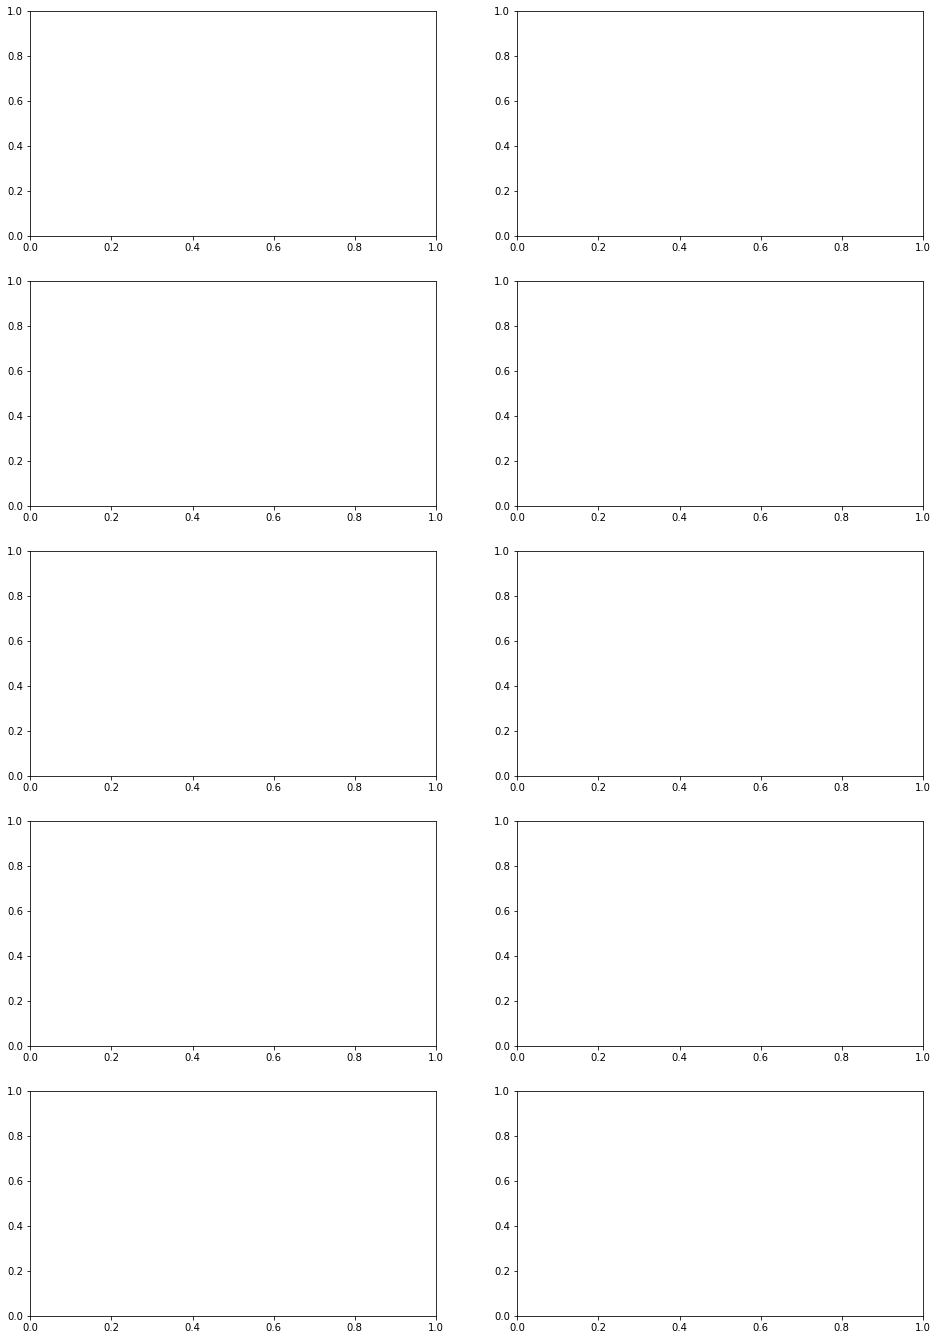

In [18]:
render_scene(0)